## Introduction

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.utils import make_grid
from PIL import Image
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import shutil
from tensorflow.keras import layers, Model
from pathlib import Path
from tensorflow.keras.layers import LeakyReLU
from dataclasses import dataclass

## EDA and Loading

The following code loads the monet paintings and hte photos into two sets of train test splits. I then used tensorflow to create the datasets with standar sizes with appropriate batch sizes. I also created the final testing dataset called `photo_ds`, this will be used in the final testing phase when I have my finished model.

In [2]:
# Load dataset /kaggle/input/gan-getting-started
def load_image(filename, target_size=(256, 256)):
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, target_size)
    image = (image / 127.5) - 1  # Normalize to [-1, 1]
    return image

# Data pipeline
def preprocess_dataset(file_pattern, batch_size=32, buffer_size=1000):
    dataset = tf.data.Dataset.list_files(file_pattern)
    dataset = dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(buffer_size).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset
# Load image paths
def get_image_paths(directory):
    return [os.path.join(directory, fname) for fname in os.listdir(directory) if fname.endswith(('.jpg', '.jpeg', '.png'))]

# Prepare datasets

monet_paths = get_image_paths('/kaggle/input/gan-getting-started/monet_jpg')
photo_paths = get_image_paths('/kaggle/input/gan-getting-started/photo_jpg')
test_path = '/kaggle/input/gan-getting-started/photo_jpg'


photo_image_paths = [os.path.join(test_path, fname) for fname in os.listdir(test_path)]
monet_train, monet_test = train_test_split(monet_paths, test_size=0.2, random_state=42)
photo_train, photo_test = train_test_split(photo_paths, test_size=0.2, random_state=42)

# Create TensorFlow datasets
def create_tf_dataset(image_paths, batch_size=32, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    dataset = dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(image_paths))
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset


def image_generator(image_paths):
    for path in image_paths:
        yield load_image(path)

photo_ds = tf.data.Dataset.from_generator(
    lambda: image_generator(photo_image_paths),
    output_signature=tf.TensorSpec(shape=(256, 256, 3), dtype=tf.float32)
)


monet_train_ds = create_tf_dataset(monet_train)
monet_test_ds = create_tf_dataset(monet_test, shuffle=False)
photo_train_ds = create_tf_dataset(photo_train)
photo_test_ds = create_tf_dataset(photo_test, shuffle=False)

There isnt alot of EDA for this dataset since it is mostly image data, so all I gathered was the sample sizes of the datasets as seen below and I printed some examples from the input to get an understanding as to what the images looked like.

In [3]:
num_samples = sum(1 for _ in photo_ds)
print("Number of samples:", num_samples)

Number of samples: 7038


In [4]:
num_samples = sum(1 for _ in monet_train_ds)
print("Number of samples:", num_samples)

Number of samples: 8


In [5]:
num_samples = sum(1 for _ in photo_train_ds)
print("Number of samples:", num_samples)

Number of samples: 176


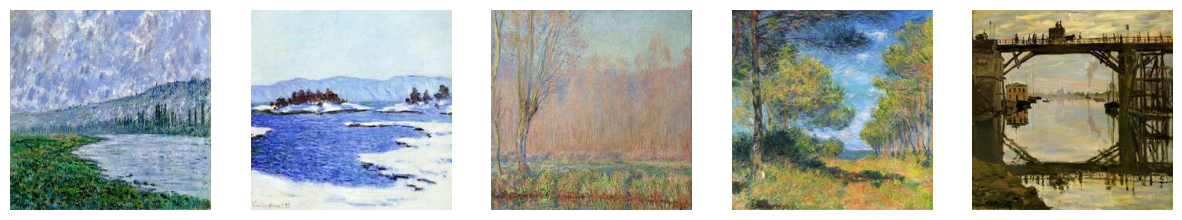

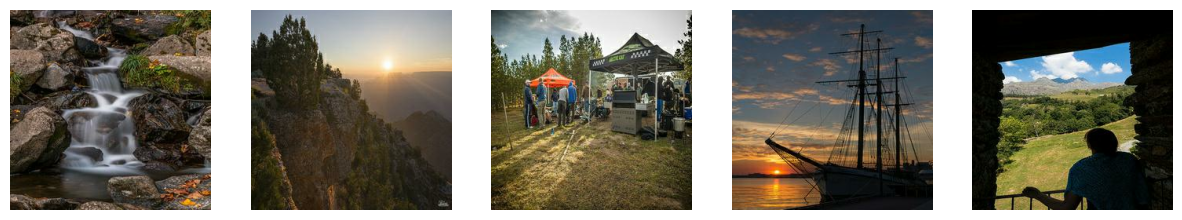

In [6]:
def visualize_dataset(dataset, num_images=5):
    for images in dataset.take(1):
        images = (images + 1) / 2  # Rescale from [-1, 1] to [0, 1]
        plt.figure(figsize=(15, 5))
        for i in range(num_images):
            plt.subplot(1, num_images, i + 1)
            plt.imshow(images[i].numpy())
            plt.axis("off")
        plt.show()

visualize_dataset(monet_train_ds)
visualize_dataset(photo_train_ds)

## Modeling 

The modeling for this notebook comes in two main parts, creating the generator and discriminator for each layer, then creating a trainer class to handle the functionality of said generator and discriminator. I will be using tensor flow for the majority of this and as such, the layer generation for the generator and discriminator just use keras. The GANTrainer class is a compiled mixture of other kaggle examples and the readings to coble together some resemblence of a GANTrainer. I opted to not use CycleGANs since I tried to code it once and it kept failing due to some data piping error I was never able to figure out. Essentially it just trains an image each epoch with weights, noise, and gradients, then repeats the process for every image in the dataset to train the model to create a fake monet painting.

In [7]:
def build_generator():
    inputs = layers.Input(shape=(256, 256, 3))  # Input photo
    
    # Downsampling
    x = layers.Conv2D(64, kernel_size=4, strides=2, padding='same', activation='relu')(inputs)
    x = layers.Conv2D(128, kernel_size=4, strides=2, padding='same', activation='relu')(x)
    x = layers.Conv2D(256, kernel_size=4, strides=2, padding='same', activation='relu')(x)  # Additional layer
    
    # Residual Blocks
    for _ in range(6):
        res = layers.Conv2D(256, kernel_size=3, padding='same', activation='relu')(x)  # Larger layers
        res = layers.Conv2D(256, kernel_size=3, padding='same', activation=None)(res)
        x = layers.add([x, res])  # Add input and transformed output

    # Upsampling
    x = layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding='same', activation='relu')(x)  # Larger layers
    x = layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding='same', activation='relu')(x)  # Larger layers
    outputs = layers.Conv2DTranspose(3, kernel_size=4, strides=2, padding='same', activation='tanh')(x)  # Normalize output to [-1, 1]
    
    return Model(inputs, outputs, name="Generator")



generator = build_generator()
generator.summary()


def build_discriminator():
    inputs = layers.Input(shape=(256, 256, 3))  # Input image (real or generated)
    
    # Downsampling with LeakyReLU activations
    x = layers.Conv2D(64, kernel_size=4, strides=2, padding='same')(inputs)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Conv2D(128, kernel_size=4, strides=2, padding='same')(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Conv2D(256, kernel_size=4, strides=2, padding='same')(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Conv2D(512, kernel_size=4, strides=2, padding='same')(x)  # Additional layer
    x = layers.LeakyReLU(alpha=0.2)(x)

    # Final Classification Layer
    outputs = layers.Conv2D(1, kernel_size=4, strides=1, padding='same', activation='sigmoid')(x)  # Patch-level output
    
    return Model(inputs, outputs, name="Discriminator")




discriminator = build_discriminator()
discriminator.summary()

Model: "Generator"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      3,136 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 64,    │    131,200 │ conv2d[0][0]      │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │    524,544 │ conv2d_1[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 32, 32,    │    590,080 │ conv2d_2[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │    590,080 │ conv2d_3[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 32, 32,    │          0 │ conv2d_2[0][0],   │
│                     │ 256)              │            │ conv2d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    590,080 │ add[0][0]         │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │    590,080 │ conv2d_5[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 32, 32,    │          0 │ add[0][0],        │
│                     │ 256)              │            │ conv2d_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │    590,080 │ add_1[0][0]       │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 32, 32,    │    590,080 │ conv2d_7[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 32, 32,    │          0 │ add_1[0][0],      │
│                     │ 256)              │            │ conv2d_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 32, 32,    │    590,080 │ add_2[0][0]       │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 32, 32,    │    590,080 │ conv2d_9[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 32, 32,    │          0 │ add_2[0][0],      │
│                     │ 256)              │            │ conv2d_10[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 32, 32,    │    590,080 │ add_3[0][0]     

 Total params: 8,398,467 (32.04 MB)

 Trainable params: 8,398,467 (32.04 MB)

 Non-trainable params: 0 (0.00 B)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 128, 128, 64)   │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 64, 64, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 32, 32, 256)    │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 16, 16, 512)    │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 16, 16, 1)      │         8,193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,764,737 (10.55 MB)

 Trainable params: 2,764,737 (10.55 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
import tensorflow as tf
from tensorflow.keras import layers, Model
import matplotlib.pyplot as plt
import numpy as np

class GANTrainer:
    def __init__(self, generator, discriminator, train_data, val_data, save_path=None, epochs=5, batch_size=32, lr=0.0002, beta_1=0.5):
        self.generator = generator
        self.discriminator = discriminator
        self.train_data = train_data
        self.val_data = val_data
        self.epochs = epochs
        self.batch_size = batch_size
        self.save_path = save_path

        # Optimizers
        self.g_optimizer = tf.keras.optimizers.Adam(learning_rate=lr, beta_1=beta_1)
        self.d_optimizer = tf.keras.optimizers.Adam(learning_rate=lr, beta_1=beta_1)

        # Loss function
        self.loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)
        
        # Prepare directory for saving models if required
        if save_path:
            self.save_path.mkdir(parents=True, exist_ok=True)
    
    def generator_loss(self, fake_output):
        """Loss for generator: encourages discriminator to classify fake as real."""
        return self.loss_fn(tf.ones_like(fake_output), fake_output)

    def discriminator_loss(self, real_output, fake_output, real_images, fake_images):
        """Loss for discriminator: classify real as real and fake as fake, with gradient penalty."""
        # Binary cross-entropy loss
        real_loss = self.loss_fn(tf.ones_like(real_output), real_output)
        fake_loss = self.loss_fn(tf.zeros_like(fake_output), fake_output)
        
        # Compute the gradient penalty
        gp = self.gradient_penalty(real_images, fake_images)
        
        # Total discriminator loss with gradient penalty
        total_loss = real_loss + fake_loss + 10.0 * gp  # 10.0 is the lambda term for the penalty
        return total_loss

    @tf.function
    def train_step(self, real_images):
        # Ensure real_images and fake_images have the same batch size
        batch_size = tf.shape(real_images)[0]
        noise = tf.random.normal([batch_size, 256, 256, 3])
        
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            # Generate fake images
            fake_images = self.generator(noise, training=True)
            
            # Discriminator predictions
            real_output = self.discriminator(real_images, training=True)
            fake_output = self.discriminator(fake_images, training=True)
            
            # Losses
            g_loss = self.generator_loss(fake_output)
            d_loss = self.discriminator_loss(real_output, fake_output, real_images, fake_images)
        
        # Compute gradients and apply updates
        gen_gradients = gen_tape.gradient(g_loss, self.generator.trainable_variables)
        disc_gradients = disc_tape.gradient(d_loss, self.discriminator.trainable_variables)
    
        self.g_optimizer.apply_gradients(zip(gen_gradients, self.generator.trainable_variables))
        self.d_optimizer.apply_gradients(zip(disc_gradients, self.discriminator.trainable_variables))
        
        return g_loss, d_loss


    def train(self):
        for epoch in range(self.epochs):
            print(f"Epoch {epoch + 1}/{self.epochs}")
            for step, real_images in enumerate(self.train_data):
                g_loss, d_loss = self.train_step(real_images)
                if step % 100 == 0:
                    print(f"Step {step}: Generator Loss = {g_loss.numpy()}, Discriminator Loss = {d_loss.numpy()}")
    
            # Visualize generated images after each epoch
            self.generate_and_save_images(epoch + 1)
    
            # Optional: Save models only if save_path is provided
            if self.save_path:
                print(f"Skipping model saving for epoch {epoch + 1}")
                # self.generator.save(self.save_path / f"generator_epoch_{epoch + 1}.h5")
                # self.discriminator.save(self.save_path / f"discriminator_epoch_{epoch + 1}.h5")


    def gradient_penalty(self, real_images, fake_images):
        """Compute the gradient penalty for WGAN-GP."""
        # Get random alpha values for interpolation
        batch_size = tf.shape(real_images)[0]
        alpha = tf.random.normal([batch_size, 1, 1, 1], mean=0.0, stddev=1.0)
        
        # Broadcast alpha to match the shape of the images (real_images and fake_images)
        alpha = tf.broadcast_to(alpha, tf.shape(real_images))
    
        # Interpolate between real and fake images
        interpolated_images = alpha * real_images + (1 - alpha) * fake_images
        
        # Watch the interpolated images to compute the gradient
        with tf.GradientTape() as tape:
            tape.watch(interpolated_images)
            pred = self.discriminator(interpolated_images, training=True)
        
        # Calculate the gradients with respect to the interpolated images
        gradients = tape.gradient(pred, interpolated_images)
        gradients = tf.reshape(gradients, [batch_size, -1])  # Flatten for norm calculation
        
        # Compute the L2 norm of the gradients
        gradient_norm = tf.norm(gradients, axis=1)
        
        # Compute the gradient penalty (WGAN-GP loss term)
        gp = tf.reduce_mean((gradient_norm - 1.0) ** 2)
        return gp


    def generate_and_save_images(self, epoch):
        """Generate and save images from the generator."""
        noise = tf.random.normal([1, 256, 256, 3])
        fake_images = self.generator(noise, training=False)
        fake_images = (fake_images + 1) / 2.0  # Normalize to [0, 1] for visualization

        fig = plt.figure(figsize=(8, 8))
        for i in range(fake_images.shape[0]):
            plt.subplot(4, 4, i + 1)
            plt.imshow(fake_images[i])
            plt.axis('off')
        plt.suptitle(f"Generated Images at Epoch {epoch}")
        plt.show()

In [9]:
trainer = GANTrainer(generator, discriminator, monet_train_ds, photo_train_ds, save_path=Path("./models"), epochs=10)

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/nn.py:674: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Step 0: Generator Loss = 0.6927173137664795, Discriminator Loss = 7.696572780609131


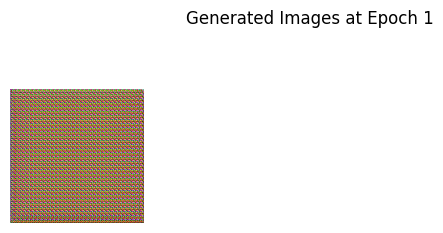

Skipping model saving for epoch 1
Epoch 2/10
Step 0: Generator Loss = 0.8444274663925171, Discriminator Loss = 1.3124879598617554


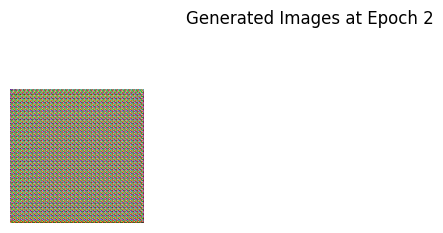

Skipping model saving for epoch 2
Epoch 3/10
Step 0: Generator Loss = 0.8131400942802429, Discriminator Loss = 1.5929853916168213


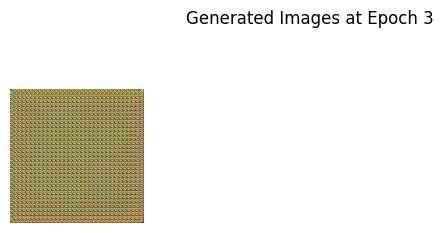

Skipping model saving for epoch 3
Epoch 4/10
Step 0: Generator Loss = 0.7412704229354858, Discriminator Loss = 1.1621787548065186


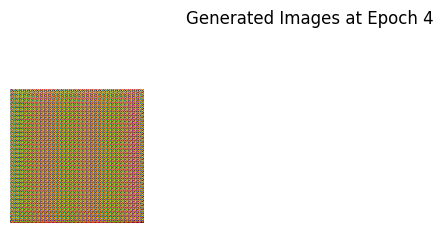

Skipping model saving for epoch 4
Epoch 5/10
Step 0: Generator Loss = 0.9093252420425415, Discriminator Loss = 1.3003759384155273


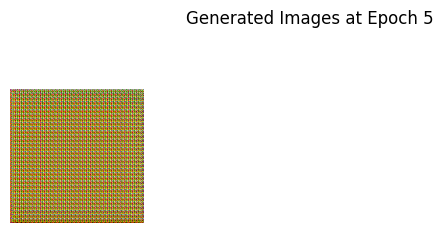

Skipping model saving for epoch 5
Epoch 6/10
Step 0: Generator Loss = 0.8832147121429443, Discriminator Loss = 1.0504200458526611


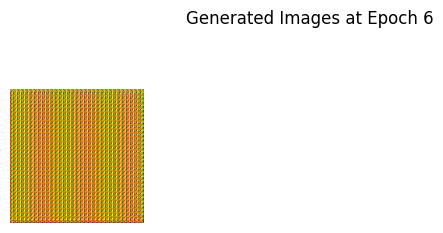

Skipping model saving for epoch 6
Epoch 7/10
Step 0: Generator Loss = 0.9693355560302734, Discriminator Loss = 0.9847604036331177


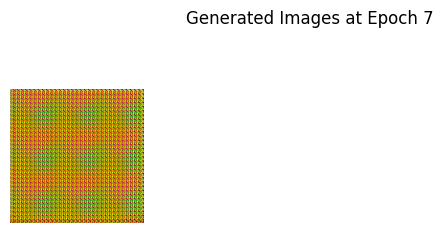

Skipping model saving for epoch 7
Epoch 8/10
Step 0: Generator Loss = 0.8980473279953003, Discriminator Loss = 0.9877734780311584


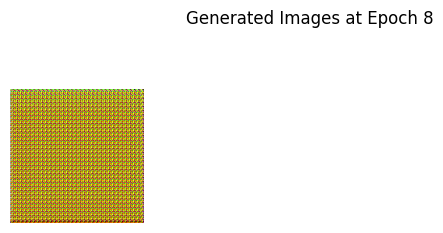

Skipping model saving for epoch 8
Epoch 9/10
Step 0: Generator Loss = 0.855495810508728, Discriminator Loss = 1.2014203071594238


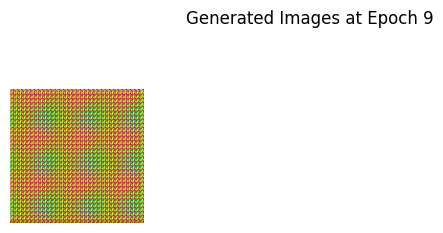

Skipping model saving for epoch 9
Epoch 10/10
Step 0: Generator Loss = 1.0814785957336426, Discriminator Loss = 1.1156742572784424


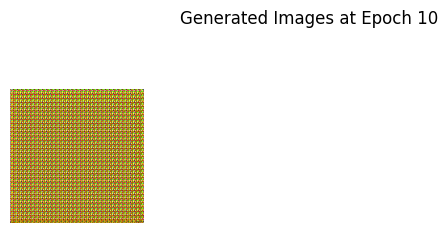

Skipping model saving for epoch 10


In [10]:
trainer.train()

The above are the results from training as we can see, the model is very bad at best. This would require hours of tweaking and testing to understand how I can get it to learn at a decent rate but I don't necessarly have the time right now. The base model is there and the concept works to a degree, so we are just going to move onto generating the fake photos. I am not going to be tuning hyperparameters since my base model is so bad that no ammount of tweaking small values would help. I would need to restruture how many layers I have, what function they use, their size, etc. and that computational time is too large for this notebook to run efficiently enough for me to keep comitting and testing

In [11]:
!mkdir ../images

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


## Testing and Submission

The below codes just uses the full `photo_ds` to generate the 7k+ fake monet paintings based on the provided images. It then saves the images to the images submission folder to then be sent to kaggle as the output.

In [12]:
with tf.device('/GPU:0'):  # You can change this if you want to use GPU
    for i, real_images in enumerate(photo_ds):  # Assuming you want to use the monet_test_ds dataset for testing
        # Generate fake images using the generator
        noise = tf.random.normal([real_images.shape[0], 256, 256, 3])  # Adjust noise shape accordingly
        fake_images = trainer.generator(noise, training=False)  # Get generator output
        
        # Post-process the generated images
        fake_images = fake_images[0].numpy()  # Assuming batch size is 1 for each loop iteration
        fake_images = (fake_images * 0.5 + 0.5) * 255  # Rescale to [0, 255]
        fake_images = np.clip(fake_images, 0, 255).astype(np.uint8)

        # Save the generated image
        img = Image.fromarray(fake_images)
        img.save(f"../images/{i}.jpg")

In [13]:
# Zip the images for submission
shutil.make_archive("/kaggle/working/images", 'zip', "../images")

'/kaggle/working/images.zip'

## Discussion

This was by far the most complex notebook I had ever coded. From reading about GANs to looking up examples, it was very difficult to figure out how each piece of the puzzle worked together especially when I had never used tensor flow before. From this experience I have learned to create a class for handling at the very least a basic trainign for a GANs trainer and have learned that it takes serious time and dedication to creating a model that can learn trends based on data to then replicate on a seperate set. This, while being a very annoying notebook, as also been one of the most intersting. 